In [2]:
import pandas as pd
from my_functions import obrada, get_limits, generate_all_timestamps, make_table, check_holes_better,  filter_rows
import numpy as np
from matplotlib import pyplot as plt

funkcija koja stavlja nanove u rupe frekvencije f

In [2]:
#df.resample('1D').mean()

popunjava rupe s vrijednosti koja je prva prije rupe/prva poslije rupe

In [3]:
#df.resample('1D').mean().bfill()

In [4]:
#df.resample('1D').mean().ffill()

interpolira rupe vrijednostima tako da se ravnomjerno popuni od podatka prije do prvog poslije

In [5]:
#df.resample('1D').mean().interpolate()

zelim naci infromaciju koliko dugo bojler radi u prosjeku
prvo moram izdvojit sve intervale kad radi u komadu (da nema rupe izmedu), nac duration izmedu njih i onda izracunat prosjeke
prvo nadem sve rupe, onda filtriram sve trenutke u kojima je bojelr upaljen iz originalnog df-a,idem po retcima i dok god donji rub nije gornji rub neke rupe, to je jedan kontinuiran rad bojlera


In [17]:
df = pd.read_csv(r'D:\Users\matea\Documents\3.god\projekt_r\bojler\2023\bojler_9_2023-filled.csv', usecols=['time','total_active_power'], parse_dates=['time'], encoding='latin1')
df.set_index('time', inplace=True)

In [19]:
gaps = obrada(9,2023,pd.to_timedelta('00:00:03'))

df = pd.read_csv(r'D:\Users\matea\GitLab\projekt-r\filled_9_2023.csv', usecols=['time','total_active_power'], parse_dates=['time'], encoding='latin1')
df.set_index('time', inplace=True)

            start-time            end-time        duration
0  2023-09-01 16:24:32 2023-09-01 16:24:45 0 days 00:00:13
1  2023-09-04 12:48:14 2023-09-04 12:48:22 0 days 00:00:08
2  2023-09-05 12:27:49 2023-09-05 12:28:00 0 days 00:00:11
3  2023-09-05 12:28:02 2023-09-05 12:28:06 0 days 00:00:04
4  2023-09-07 16:18:16 2023-09-07 16:18:24 0 days 00:00:08
5  2023-09-07 16:18:24 2023-09-07 16:18:30 0 days 00:00:06
6  2023-09-07 16:18:30 2023-09-07 16:18:34 0 days 00:00:04
7  2023-09-08 12:28:45 2023-09-08 12:28:49 0 days 00:00:04
8  2023-09-11 17:05:59 2023-09-11 17:06:11 0 days 00:00:12
9  2023-09-11 17:06:11 2023-09-11 17:06:33 0 days 00:00:22
10 2023-09-11 17:06:33 2023-09-11 17:06:37 0 days 00:00:04
11 2023-09-11 17:21:48 2023-09-11 17:21:52 0 days 00:00:04
12 2023-09-11 20:22:41 2023-09-11 20:22:45 0 days 00:00:04
13 2023-09-11 20:22:45 2023-09-11 20:22:50 0 days 00:00:05
14 2023-09-11 20:22:54 2023-09-11 20:22:58 0 days 00:00:04
15 2023-09-15 06:00:19 2023-09-19 13:05:08 4 days 07:04:

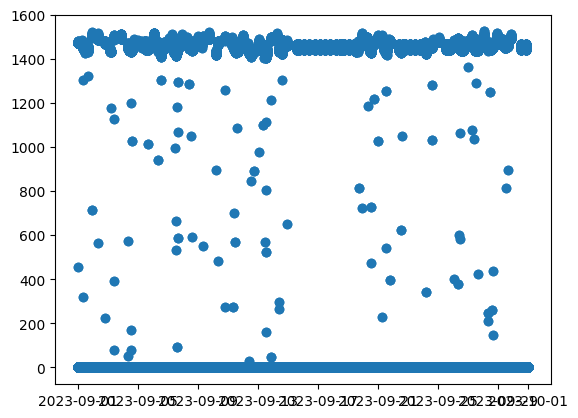

In [34]:
plt.scatter(df['time'],df['total_active_power'])

Iscrtavanje popunjenog mjeseca

C:\Users\matea\AppData\Local\Temp\ipykernel_17320\3430306692.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_filled_data = pd.concat([new_filled_data, df[mask]])
C:\Users\matea\AppData\Local\Temp\ipykernel_17320\3430306692.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_filled_data = pd.concat([new_filled_data, df[mask]])


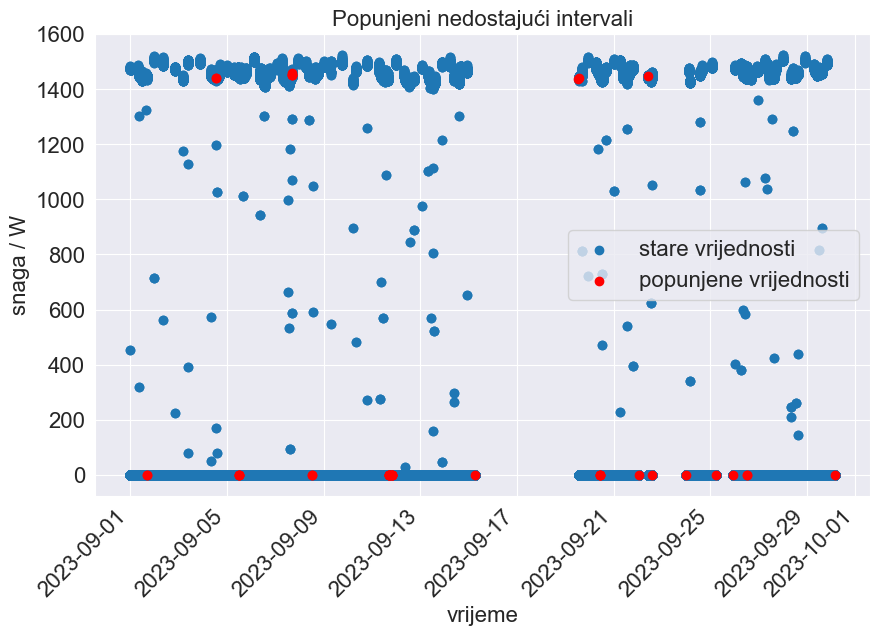

In [20]:
original_data = pd.DataFrame(columns=df.columns)
new_filled_data = pd.DataFrame(columns=df.columns)

for _, row in gaps.iterrows():
    start_time = row['start-time']
    end_time = row['end-time']
    mask = (df.index >= start_time) & (df.index <= end_time)
    new_filled_data = pd.concat([new_filled_data, df[mask]])
    df = df[~mask]

original_data = df
plt.figure(figsize=(10, 6))

plt.scatter(original_data.index, original_data['total_active_power'], label='stare vrijednosti')

plt.scatter(new_filled_data.index, new_filled_data['total_active_power'], label='popunjene vrijednosti', color='red')

plt.title('Popunjeni nedostajući intervali', fontsize=16)
plt.xlabel('vrijeme', fontsize=16)
plt.ylabel('snaga / W', fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.legend(loc='center right', fontsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.show()


bolje prvo nac sve kontinuirane intervale rada bojlera, a onda jos ubacit rupe u to
treba prvo nekako odredit granice, ostavt samo retke s nulama koji su granice između intervala
kod dolje racuna sve kontinuirane intervale rada bojlera

In [11]:
df2  = pd.DataFrame(columns=['start-time', 'end-time'])
intervals = []
start=pd.to_datetime("{}-{}-01 00:00:00".format(2023,9))
for index, row in df.iterrows():
    if(row['total_active_power']==0):
        if((index+1)!=len(df) and df.loc[index+1, 'total_active_power']>0):
            start = df.loc[index+1,'time']
        #cekamo da nademo prvi trenutak u kojem se bojler upalio
    #razmak između ovog i sljedecg retka je manji ili jednak 3s, ovaj redak nije nula
    elif((index+1)!=len(df) and df.loc[index+1, 'time']-row['time']<=pd.to_timedelta('00:00:03')):
        #sljedeci redak nije nula
        if not (df.loc[index+1, 'total_active_power']>0):
            #dosli smo do kraja kontinuuma
            end=row['time']
            intervals.append({'start-time': start, 'end-time': end})
    elif((index+1)==len(df)):
        #sljedeci redak ne postoji, ovo je zadnji i nije bio nula
        end=row['time']
        intervals.append({'start-time': start, 'end-time': end})
    else:
        #imamo vise od 3 s rupe u buducnosti
        end=row['time']
        intervals.append({'start-time': start, 'end-time': end})

df2 = pd.DataFrame(intervals)
df2['duration'] = df2['end-time'] - df2['start-time']
df2

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [18]:
mean = df2['duration'].where(df2['duration']>pd.to_timedelta('0')).mean()
maximum = df2['duration'].max()

prosjecno trajanje kontinuiranog rada bojlera:

In [185]:
mean

Timedelta('0 days 00:08:32.434599156')

In [2]:
gaps = obrada(9,2023,pd.to_timedelta('00:00:03'))
#gaps[gaps['duration']>pd.to_timedelta('00:30:00')]

            start-time            end-time        duration
0  2023-09-01 16:24:32 2023-09-01 16:24:45 0 days 00:00:13
1  2023-09-04 12:48:14 2023-09-04 12:48:22 0 days 00:00:08
2  2023-09-05 12:27:49 2023-09-05 12:28:00 0 days 00:00:11
3  2023-09-05 12:28:02 2023-09-05 12:28:06 0 days 00:00:04
4  2023-09-07 16:18:16 2023-09-07 16:18:24 0 days 00:00:08
5  2023-09-07 16:18:24 2023-09-07 16:18:30 0 days 00:00:06
6  2023-09-07 16:18:30 2023-09-07 16:18:34 0 days 00:00:04
7  2023-09-08 12:28:45 2023-09-08 12:28:49 0 days 00:00:04
8  2023-09-11 17:05:59 2023-09-11 17:06:11 0 days 00:00:12
9  2023-09-11 17:06:11 2023-09-11 17:06:33 0 days 00:00:22
10 2023-09-11 17:06:33 2023-09-11 17:06:37 0 days 00:00:04
11 2023-09-11 17:21:48 2023-09-11 17:21:52 0 days 00:00:04
12 2023-09-11 20:22:41 2023-09-11 20:22:45 0 days 00:00:04
13 2023-09-11 20:22:45 2023-09-11 20:22:50 0 days 00:00:05
14 2023-09-11 20:22:54 2023-09-11 20:22:58 0 days 00:00:04
15 2023-09-15 06:00:19 2023-09-19 13:05:08 4 days 07:04:

,start-time,end-time,duration
77,2023-04-12 12:44:17,2023-04-12 12:45:10,0 days 00:00:53
78,2023-04-12 14:01:46,2023-04-12 14:08:22,0 days 00:06:36
79,2023-04-12 14:10:26,2023-04-12 14:10:54,0 days 00:00:28
80,2023-04-16 15:09:44,2023-04-16 15:27:35,0 days 00:17:51
81,2023-04-17 00:22:01,2023-04-17 10:12:48,0 days 09:50:47
82,2023-04-30 00:00:00,2023-04-30 23:59:59,0 days 23:59:59


In [43]:
df[df['time'] == pd.to_datetime('2023-10-7 00:22:01')]

,time,total_active_power


treba dodati retke s razmakom 3 s unutar svih rupa, i oznaciti koja je bila vrsta rupe da se kasnije moze lakse odrediti kako koju puniti

In [12]:
df_filled=pd.DataFrame(columns=df.columns)
df_filled['gap_type'] = 0
filled_data = []
for index, row in gaps.iterrows():
    start = row['start-time']
    end = row['end-time']
    print(start,end)
    all_timestamps = pd.date_range(start=start, end=end - pd.to_timedelta('00:00:03'), freq=pd.to_timedelta('00:00:03'), inclusive='neither')
    if end - start == pd.to_timedelta('00:00:04'):
        all_timestamps=all_timestamps.append(pd.Index([start + pd.to_timedelta('00:00:02')]))
    elif end - start == pd.to_timedelta('00:00:05') or end - start == pd.to_timedelta('00:00:06'):
        all_timestamps=all_timestamps.append(pd.Index([start + pd.to_timedelta('00:00:03')]))
    elif(end - all_timestamps[-1] == pd.to_timedelta('00:00:04')):
        #ostala je jos rupa od 4s, radije bismo da su dvije nego 1 na kraju
        all_timestamps=all_timestamps.append(pd.Index([all_timestamps[-1] + pd.to_timedelta('00:00:02')]))
    else:
        all_timestamps=all_timestamps.append(pd.Index([all_timestamps[-1] + pd.to_timedelta('00:00:03')]))

    gap_type = 1 if (row['duration'] < pd.to_timedelta('00:10:00') ) else 2 
        #if row['duration']<pd.to_timedelta('01:00:00') else 3
    filled_data.append(pd.DataFrame({'time': all_timestamps, 'gap_type': gap_type}))
df_filled = pd.concat(filled_data, ignore_index=True)
df_filled.sort_values(by='time')

df_filled

2023-09-01 16:24:32 2023-09-01 16:24:45
2023-09-04 12:48:14 2023-09-04 12:48:22
2023-09-05 12:27:49 2023-09-05 12:28:00
2023-09-05 12:28:02 2023-09-05 12:28:06
2023-09-07 16:18:16 2023-09-07 16:18:24
2023-09-07 16:18:24 2023-09-07 16:18:30
2023-09-07 16:18:30 2023-09-07 16:18:34
2023-09-08 12:28:45 2023-09-08 12:28:49
2023-09-11 17:05:59 2023-09-11 17:06:11
2023-09-11 17:06:11 2023-09-11 17:06:33
2023-09-11 17:06:33 2023-09-11 17:06:37
2023-09-11 17:21:48 2023-09-11 17:21:52
2023-09-11 20:22:41 2023-09-11 20:22:45
2023-09-11 20:22:45 2023-09-11 20:22:50
2023-09-11 20:22:54 2023-09-11 20:22:58
2023-09-15 06:00:19 2023-09-19 13:05:08
2023-09-19 13:05:08 2023-09-19 13:10:18
2023-09-20 10:32:20 2023-09-20 10:32:24
2023-09-20 10:34:41 2023-09-20 10:34:46
2023-09-22 01:19:46 2023-09-22 09:50:18
2023-09-22 14:08:20 2023-09-23 23:38:19
2023-09-25 05:24:43 2023-09-25 22:31:00
2023-09-26 12:16:05 2023-09-26 12:16:17
2023-09-30 03:26:15 2023-09-30 23:59:59


,time,gap_type
0,2023-09-01 16:24:35,1
1,2023-09-01 16:24:38,1
2,2023-09-01 16:24:41,1
3,2023-09-01 16:24:43,1
4,2023-09-04 12:48:17,1
...,...,...
219437,2023-09-30 23:59:45,2
219438,2023-09-30 23:59:48,2
219439,2023-09-30 23:59:51,2
219440,2023-09-30 23:59:54,2


In [13]:
filled_df = pd.concat([df, df_filled], ignore_index=True, sort=False)
filled_df = filled_df.sort_values(by='time').reset_index(drop=True)

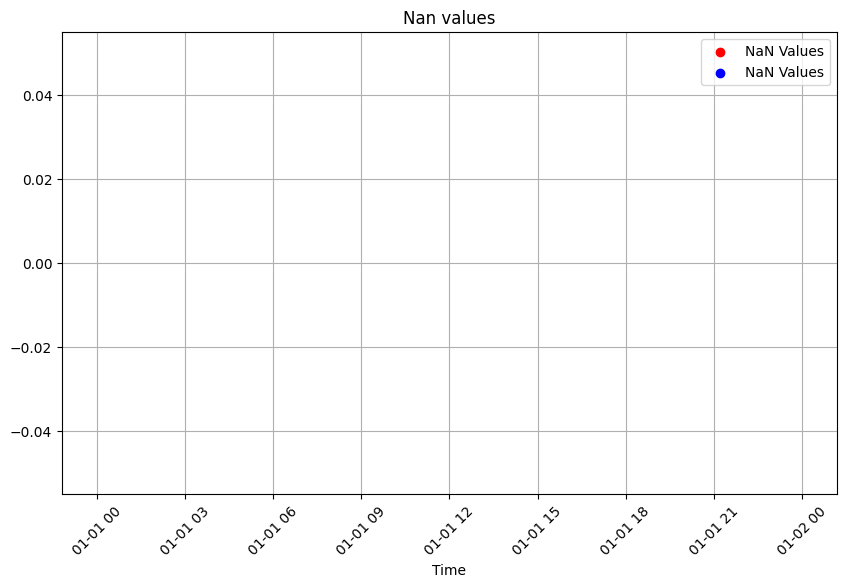

In [9]:
def power_graph(df):
    plt.figure(figsize=(10, 6))
    nan_mask = df['total_active_power'].isna() & (df['time'] >= pd.to_datetime('2023-10-07 12:00:00')) & (df['time'] <= pd.to_datetime('2023-10-07 16:00:00'))
    plt.scatter(df.loc[nan_mask, 'time'], [1]*len(df.loc[nan_mask, 'time']), marker='o', label='NaN Values', color='red')
    maks= df['total_active_power'].notna() & (df['time'] >= pd.to_datetime('2023-10-07 12:00:00')) & (df['time'] <= pd.to_datetime('2023-10-07 16:00:00'))
    plt.scatter(df.loc[maks, 'time'], df.loc[maks,'total_active_power'], marker='o', label='NaN Values', color='blue')

    plt.title('Nan values')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

power_graph(filled_df)

In [24]:
m=(df['time'] >= pd.to_datetime('2023-10-07 00:00:00')) 
df.loc[m]

,time,total_active_power
0,2022-04-07 14:13:36,0.0
1,2022-04-07 14:13:41,0.0
2,2022-04-07 14:13:46,0.0
3,2022-04-07 14:13:51,0.0
4,2022-04-07 14:13:56,0.0
...,...,...
723085,2022-04-29 23:59:51,0.0
723086,2022-04-29 23:59:53,0.0
723087,2022-04-29 23:59:55,0.0
723088,2022-04-29 23:59:57,0.0


sad imam retke s nanovima i tipom rupe koji mi kaze kako da ju popunim

In [14]:
def fill_smallest_gaps(row):
    row_index = row.name
    #ako su okolne dvije nule, ili dvije vrijednosti>0, punim njihovim meanom
    top_index = filled_df.loc[:row_index, 'total_active_power'].dropna().index.max()
    bottom_index = filled_df.loc[row_index:, 'total_active_power'].dropna().index.min()
    if pd.isna(top_index):
        #ne postoji podatak prije
        bottom_value = filled_df.loc[bottom_index,'total_active_power']
        return bottom_value
    elif pd.isna(bottom_index):
        #ne postoji zadnji
        top_value = filled_df.loc[top_index,'total_active_power']
        return top_value
    top_value = filled_df.loc[top_index,'total_active_power']
    bottom_value = filled_df.loc[bottom_index,'total_active_power']
    if((top_value==0 and bottom_value==0) or (top_value>0 and bottom_value>0)):
       return (top_value+bottom_value)/2
    #okolne vrijednosti su razlicite, pogledam je li blize donja ili gornja i prema tome popunim
    elif((row_index-top_index)<(bottom_index-row_index)):
        #print(row_index, top_index, bottom_index, top_value, bottom_value)
        return top_value-9
    else:
        return bottom_value

In [15]:
filled_df.loc[filled_df['gap_type'] == 1, 'filled_power'] = filled_df[filled_df['gap_type'] == 1].apply(fill_smallest_gaps, axis=1)

In [191]:
filled_df[filled_df['gap_type']==1]

,time,total_active_power,gap_type,filled_power
62961,2023-11-02 12:26:47,NaN,1.0,0.0
361928,2023-11-09 17:22:58,NaN,1.0,0.0
403695,2023-11-10 17:32:10,NaN,1.0,0.0
645294,2023-11-16 13:21:31,NaN,1.0,1432.0
647177,2023-11-16 14:26:47,NaN,1.0,0.0
647178,2023-11-16 14:26:50,NaN,1.0,0.0
647179,2023-11-16 14:26:53,NaN,1.0,0.0
647180,2023-11-16 14:26:56,NaN,1.0,0.0
683098,2023-11-17 11:13:56,NaN,1.0,0.0
683099,2023-11-17 11:13:59,NaN,1.0,0.0


za rupe tipa 2, pogledati koje su okolne vrijednosti, ako su obje nula punim nulama
ako su razlicite, gledam kad je krenula ne nula, nadopunjavam ju do prosjecnog vremena rada bojlera, ostatak nulama
ako su iste, gledam kad krecu i zavrsavaju, vidim je li interval dulji od maksimalnog, ako je nadopunjavam obje strane do prosjeka ostatak nulama, ako nije samo sve popunim?

In [16]:
def fill_medium_gaps(row):
    row_index = row.name
    top_index = filled_df.loc[:row_index, 'total_active_power'].dropna().index.max()
    bottom_index = filled_df.loc[row_index:, 'total_active_power'].dropna().index.min()
    
    #print(row_index, top_index, bottom_index, top_value, bottom_value)
    if(pd.isna(top_index)):
        #ne postoji 'prednji' podatak
        bottom_value = filled_df.loc[bottom_index,'total_active_power']
        if(bottom_value==0):
            return 0
        else:
            bottom_zero_index = filled_df.loc[row_index:, 'total_active_power'][filled_df.loc[row_index:, 'total_active_power'] == 0].index.min()
            #kraj rada bojlera
            bottom_end = bottom_zero_index-1
            end_time = filled_df.loc[bottom_end,'time']
            if(end_time-row['time']>mean):
                return 0
            else:
                return bottom_value
        #od gore se puni nulama, od dolje vrijednosti bottom value sve dok je row['time']
    elif(pd.isna(bottom_index)):
        #ne postoji donji podatak 
        top_value = filled_df.loc[top_index,'total_active_power']
        if(top_value==0):
            return 0
        else:
            top_zero_index = filled_df.loc[:row_index, 'total_active_power'][filled_df.loc[:row_index, 'total_active_power'] == 0].index.max()
            #kraj rada bojlera
            top_start = top_zero_index+1
            start_time = filled_df.loc[top_start,'time']
            if(row['time'] - start_time > mean):
                return 0
            else:
                return top_value
    top_value = filled_df.loc[top_index,'total_active_power']
    bottom_value = filled_df.loc[bottom_index,'total_active_power']
    if(top_value==0 and bottom_value==0):
        #ako su okolne dvije nule, punim nulama
       return 0
    #okolne vrijednosti nisu nule, pogledam je li blize donja ili gornja i prema tome popunim
    elif(top_value==0 and bottom_value>0):
        #trebam vrijednost prije prve nule ispod, da znam do kad bojler radi
        #ovo je prva nula ispod
        #bottom_zero_index = filled_df[filled_df.loc[row_index:, 'total_active_power']==0].index.min()
        bottom_zero_index = filled_df.loc[row_index:, 'total_active_power'][filled_df.loc[row_index:, 'total_active_power'] == 0].index.min()

        #kraj rada bojlera
        bottom_end = bottom_zero_index-1
        end_time = filled_df.loc[bottom_end,'time']
        if(end_time-row['time']>mean):
            return 0
        else:
            return bottom_value
        #od gore se puni nulama, od dolje vrijednosti bottom value sve dok je row['time']
    elif(top_value>0 and bottom_value==0):
        #trebam vrijednost nakon prve nule iznad, da znam do kad bojler radi
        #ovo je prva nula iznad
        #top_zero_index = filled_df[filled_df.loc[:row_index, 'total_active_power']==0].index.max()
        top_zero_index = filled_df.loc[:row_index, 'total_active_power'][filled_df.loc[:row_index, 'total_active_power'] == 0].index.max()

        #kraj rada bojlera
        top_start = top_zero_index+1
        start_time = filled_df.loc[top_start,'time']
        if(row['time'] - start_time > mean):
            return 0
        else:
            return top_value
    #obje strane su vece od nula
    else:
        #nadem gornji pocetak i donji kraj i vidim hoce li preci granicu maksimuma
        #bottom_zero_index = filled_df[filled_df.loc[row_index:, 'total_active_power']==0].index.min()
        bottom_zero_index = filled_df.loc[row_index:, 'total_active_power'][filled_df.loc[row_index:, 'total_active_power'] == 0].index.min()
        #kraj rada bojlera
        bottom_end = bottom_zero_index-1
        end_time = filled_df.loc[bottom_end,'time']
        #top_zero_index = filled_df[filled_df.loc[:row_index, 'total_active_power']==0].index.max()
        top_zero_index = filled_df.loc[:row_index, 'total_active_power'][filled_df.loc[:row_index, 'total_active_power'] == 0].index.max()
        #kraj rada bojlera
        top_start = top_zero_index+1
        start_time = filled_df.loc[top_start,'time']
        print(start_time, end_time)
        if(end_time-start_time>maximum):
            #preveliko je, trebat ce razdijeliti
            if(row['time'] - start_time < mean):
                #ako sam blize gornjoj granici i nije se preslo prosjek
                return top_value
            elif(end_time - row['time'] < mean):
                #blize donjoj granici i nije preslo dozvoljeno vrijeme
                return bottom_value
            else:
                return 0
        else:
            #ok je, mogu popuniti radom bojlera
            return (bottom_value+top_value)/2

In [17]:
filled_df.loc[filled_df['gap_type'] == 2, 'filled_power'] = filled_df[filled_df['gap_type'] == 2].apply(fill_medium_gaps, axis=1)



KeyboardInterrupt



In [26]:
filled_df[filled_df['gap_type']==2]


,time,total_active_power,gap_type,filled_power
597247,2023-09-15 06:00:22,NaN,2.0,0.0
597248,2023-09-15 06:00:25,NaN,2.0,0.0
597249,2023-09-15 06:00:28,NaN,2.0,0.0
597250,2023-09-15 06:00:31,NaN,2.0,0.0
597251,2023-09-15 06:00:34,NaN,2.0,0.0
...,...,...,...,...
1154263,2023-09-30 23:59:45,NaN,2.0,0.0
1154264,2023-09-30 23:59:48,NaN,2.0,0.0
1154265,2023-09-30 23:59:51,NaN,2.0,0.0
1154266,2023-09-30 23:59:54,NaN,2.0,0.0


In [29]:
filled_df.to_csv('filled_9_2023', sep=',', index=False, encoding='utf-8')

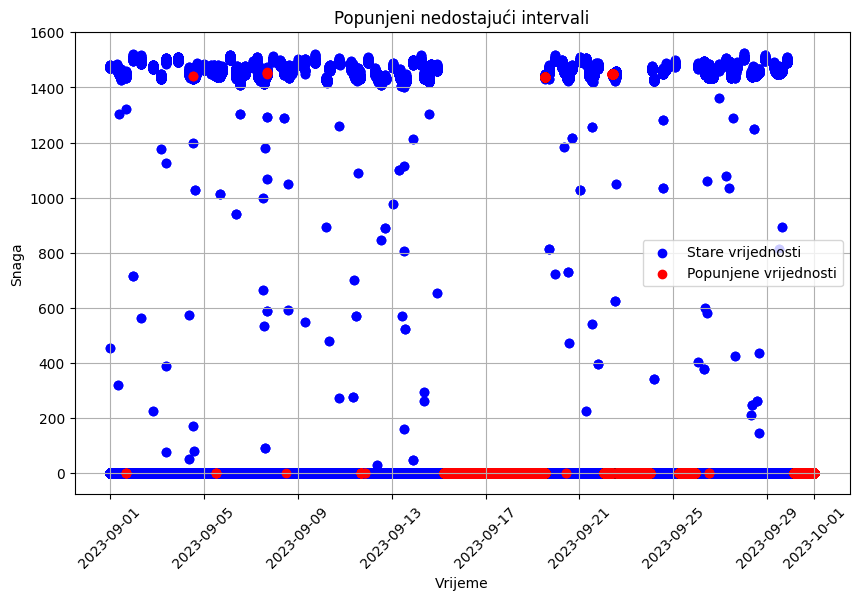

In [30]:
plt.figure(figsize=(10, 6))
#date_range_list= (filled_df['time'] >= pd.to_datetime('2023-11-09 00:00:00')) & (filled_df['time'] <= pd.to_datetime('2023-11-11 00:00:00'))
normal_list = filled_df['gap_type'].isna()
gaps_list = filled_df['gap_type'].notna()
#normal_list = filled_df['gap_type'].isna()
#gaps_list = filled_df['gap_type'].notna()
plt.scatter(filled_df.loc[normal_list, 'time'], filled_df.loc[normal_list,'total_active_power'], label='Stare vrijednosti', color='blue')
plt.scatter(filled_df.loc[gaps_list,'time'], filled_df.loc[gaps_list, 'filled_power'], label='Popunjene vrijednosti', color='red')


plt.title('Popunjeni nedostajući intervali')
plt.xlabel('Vrijeme')
plt.ylabel('Snaga')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='center right')
#plt.savefig("9-11.11_2023_popunjen.png", dpi=600, bbox_inches='tight')
plt.show()

In [203]:
#sad zelimo napravit ope tgraf rupa ali tako da uzima i filled_power u obzir
def combine_power(row):
    if pd.isna(row['total_active_power']) and pd.isna(row['filled_power']):
        return np.nan
    else:
        return row['filled_power'] if pd.notna(row['filled_power']) else row['total_active_power']

# Apply the custom function to create 'combined_power' column
filled_df['combined_power'] = filled_df.apply(combine_power, axis=1)
filled_df[filled_df['total_active_power'].isna()]


,time,total_active_power,gap_type,filled_power,combined_power
62961,2023-11-02 12:26:47,NaN,1.0,0.0,0.0
361928,2023-11-09 17:22:58,NaN,1.0,0.0,0.0
403695,2023-11-10 17:32:10,NaN,1.0,0.0,0.0
602785,2023-11-15 12:46:41,NaN,NaN,NaN,NaN
602786,2023-11-15 12:46:43,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1197382,2023-11-30 23:59:44,NaN,3.0,NaN,NaN
1197383,2023-11-30 23:59:47,NaN,3.0,NaN,NaN
1197384,2023-11-30 23:59:50,NaN,3.0,NaN,NaN
1197385,2023-11-30 23:59:53,NaN,3.0,NaN,NaN


In [205]:
novipodaci = filled_df[filled_df['combined_power'].notna()]
novipodaci.to_csv('11_2023_popunjen')

In [3]:
def create_graph(ax, all_timestamps, beginning, end, month, interval_list, step, pctg):
    ax.plot(all_timestamps, interval_list, linewidth=2)
    tick_positions = pd.date_range(start=beginning, end=end, freq='2D')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right',
                       fontsize=8)

    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('1 - rupa, 0 - zapis')
    ax.set_title("rupa:>{}s, postotak:{}%".format(int(step.total_seconds()), round(pctg, 2)))

    #fig.set_size_inches(20, 6)  # Adjust the width and height as needed
    #plt.savefig("{}m_graph.png".format(month), dpi=600, bbox_inches='tight')
    return


def make_graph(month, year, steps, save):
    print("{}. mjesec".format(month))
    end, beginning = get_limits(month, year)
    #generiranje svih 'trenutaka' u mjesecu kad bi podaci trebali biti upisani
    all_timestamps = generate_all_timestamps(beginning, end, '1S')
    #stvaranje novog prozora za novi mjesec
    fig, ax = plt.subplots(nrows=1, ncols=len(steps), figsize=(20, 5))
    fig.suptitle("{}. mjesec {}.".format(month, year))
    k = 0
    for step in steps:
        df = obrada(month, year, step)
        #true za trenutke koji su u rupi, false za one koji nisu
        interval_list = check_holes_better(all_timestamps, df, beginning)
        percentage = interval_list.count(True) / len(interval_list) * 100
        print("Postotak rupa: {} %, rupa: {}".format(round(percentage, 2), step))
        #stvaranje grafa
        if len(steps) == 1:
            create_graph(ax, all_timestamps, beginning, end, month, interval_list, step, percentage)
        else:
            create_graph(ax[k], all_timestamps, beginning, end, month, interval_list, step, percentage)
        k += 1
    #plt.title("{}. mjesec".format(month))
    if save:
        plt.savefig("{}_{}_graph_popunjennn.png".format(month, year), dpi=600, bbox_inches='tight')
    plt.show()
    return

11. mjesec
           start-time            end-time        duration
0 2023-11-15 12:46:39 2023-11-15 12:46:45 0 days 00:00:06
1 2023-11-23 09:01:30 2023-11-26 02:05:30 2 days 17:04:00
2 2023-11-29 23:59:59 2023-11-30 23:59:59 1 days 00:00:00
Postotak rupa: 12.37 %, rupa: 0 days 00:00:03


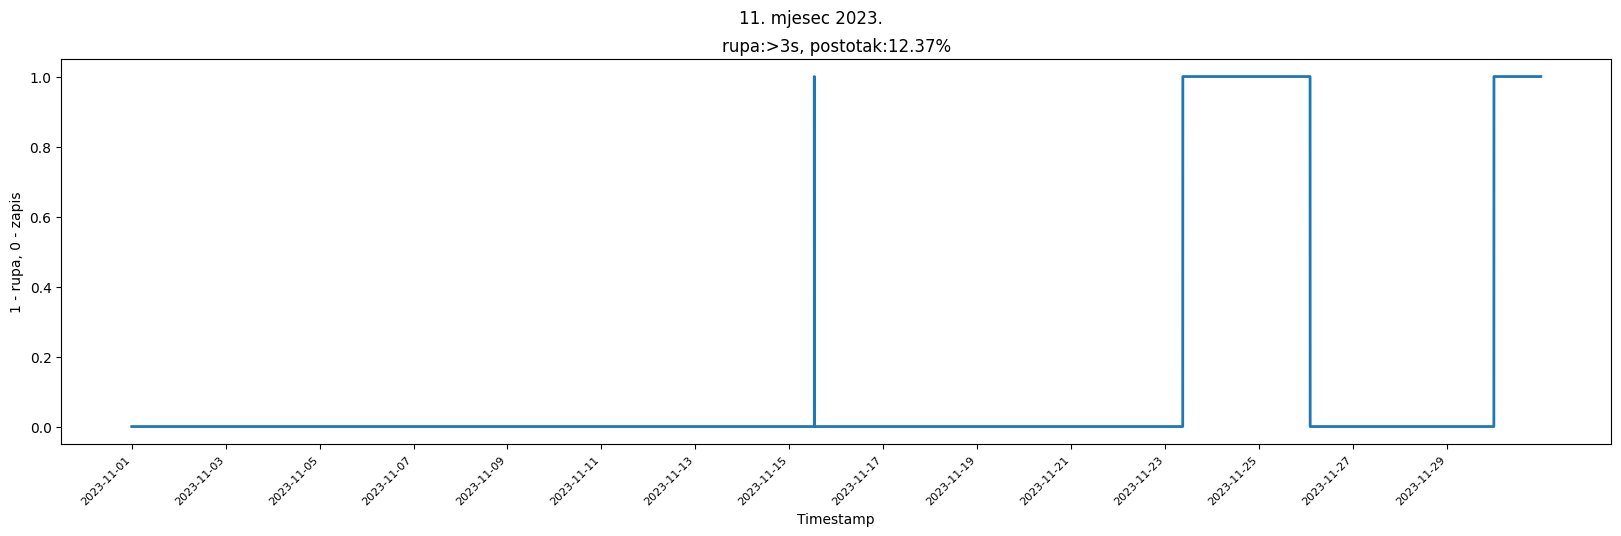

In [4]:
make_graph(11,2023,[pd.to_timedelta('00:00:03')], True)